In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tqdm.auto as tqdm
from tqdm.contrib.concurrent import process_map

import postprocess

split_ratio = 0.3
seeds = range(33, 83)
data_dir = "data/law"

max_workers = 32

/home/rxian/anaconda3/envs/fair-lite/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scipy.spatial


def get_convex_hull_lower(x, y):
  # https://stackoverflow.com/a/76839030

  def get_lower(polygon):
    minx = np.argmin(polygon[:, 0])
    maxx = np.argmax(polygon[:, 0]) + 1
    if minx >= maxx:
      lower_curve = np.concatenate([polygon[minx:], polygon[:maxx]])
    else:
      lower_curve = polygon[minx:maxx]
    return lower_curve

  points = np.stack([x, y], axis=1)
  hull = scipy.spatial.ConvexHull(points)
  lower_curve = get_lower(points[hull.vertices])
  return lower_curve

## Download LSAC Law School dataset

In [3]:
data_path = f"{data_dir}/bar_pass_prediction.csv"
if not os.path.exists(data_path):
  os.makedirs(data_dir, exist_ok=True)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv",
      data_path)

# To simpliy the case study, we will only use the columns that will be used for
# our model.
column_names = [
    'dnn_bar_pass_prediction',
    'gender',
    'lsat',
    'race1',
    'pass_bar',
    'ugpa',
]

,count,%
Group,,
asian,897,0.040804
black,1343,0.061093
hisp,1027,0.046718
white,18716,0.851385


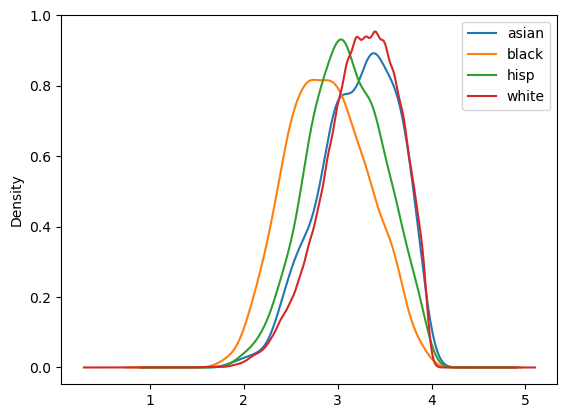

In [4]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


original = pd.read_csv(data_path,
                       index_col=0,
                       sep=r",",
                       engine="python",
                       na_values="?")

original.dropna()
original['gender'] = original['gender'].astype(str)
original['race1'] = original['race1'].astype(str)
original = original[column_names]

race = ['asian', 'black', 'hisp', 'white']
original = original[original['race1'].isin(race)]

# Transform data, and remove fold and target
data = original.copy()
data = data.drop(["ugpa"], axis=1)
data = data_transform(data)

targets = original["ugpa"].to_numpy()
# targets = (targets - 1.0) / (4.0 - 1.0)
group_names, groups = np.unique(original["race1"], return_inverse=True)
n_groups = len(group_names)

bound = (1, 4)

# Show data statistics
df = pd.DataFrame(
    zip(np.array(group_names)[groups], targets),
    columns=["Group", "Target"],
).groupby(["Group"]).agg({"count"})
df.columns = df.columns.droplevel(0)
df["%"] = df["count"] / df["count"].sum()
display(df)

df = pd.DataFrame({
  name: pd.Series(targets[groups == a]) for a, name in enumerate(group_names)
}).plot.kde()

## Fair post-processing

In [5]:
# Helper functions


def ks_dist(scores, groups):
  """Maximum pairwise KS distance"""
  n_groups = len(np.unique(groups))
  max_ks = 0
  for i in range(n_groups):
    for j in range(i + 1, n_groups):
      max_ks = max(max_ks,
                   ks_2samp(scores[groups == i], scores[groups == j]).statistic)
  return max_ks


def postprocess_and_evaluate(k_alpha_eps_seed):
  """Post-processing and evaluation using multiple CPU cores"""
  k, alpha, eps, seed = k_alpha_eps_seed

  # Split into train and test
  _, _, train_targets, test_targets, train_groups, test_groups = train_test_split(
      data,
      targets,
      groups,
      test_size=split_ratio,
      random_state=seed,
  )

  # Post-process and evaluate
  postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
      train_targets,
      train_groups,
      alpha=alpha,
      eps=eps,
      bound=bound,
      n_bins=k,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  return (mean_squared_error(test_targets, targets_test_fair),
          ks_dist(targets_test_fair, test_groups))

### Results and baselines for $\alpha = 0$

In [6]:
n_bins = 36
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]

# results[0] = mse
# results[1] = ks
# results[:, i] = methods[i]
results = np.empty((2, 3 + len(epsilons), len(seeds)))
methods = [
    "no postprocessing", "Chzhen et al. (2020)", "binning", "binning + fair"
] + [f"binning + private and fair (eps={eps})" for eps in epsilons[1:]]

for k, seed in enumerate(tqdm.tqdm(seeds)):

  # Split into train and test
  _, _, train_targets, test_targets, train_groups, test_groups = train_test_split(
      data,
      targets,
      groups,
      test_size=split_ratio,
      random_state=seed,
  )

  # No postprocessing
  results[0, 0, k] = 0
  results[1, 0, k] = ks_dist(test_targets, test_groups)

  # Chzhen et al. (2020)
  postprocessor = postprocess.WassersteinBarycenterFairPostProcessor().fit(
      train_targets,
      train_groups,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  results[0, 1, k] = mean_squared_error(test_targets, targets_test_fair)
  results[1, 1, k] = ks_dist(targets_test_fair, test_groups)

  # Binning
  postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
      train_targets,
      train_groups,
      alpha=1.0,
      bound=bound,
      n_bins=n_bins,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  results[0, 2, k] = mean_squared_error(test_targets, targets_test_fair)
  results[1, 2, k] = ks_dist(targets_test_fair, test_groups)

  # Binning + (private) fair postprocessing
  for i, eps in enumerate(epsilons):
    postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
        train_targets,
        train_groups,
        alpha=0.0,
        eps=eps,
        bound=bound,
        n_bins=n_bins,
        rng=np.random.default_rng(seed),
    )
    targets_test_fair = postprocessor.predict(test_targets, test_groups)
    results[0, 3 + i, k] = mean_squared_error(test_targets, targets_test_fair)
    results[1, 3 + i, k] = ks_dist(targets_test_fair, test_groups)

  0%|          | 0/50 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-29


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [7]:
means = results.mean(axis=2)
stds = results.std(axis=2)
df = pd.DataFrame(np.stack([means[0], stds[0], means[1], stds[1]], axis=1))
df.columns = ["mse", "mse std", "ks", "ks std"]
df.index = methods
display(df)

,mse,mse std,ks,ks std
no postprocessing,0.000000,0.000000,0.349900,0.018699
Chzhen et al. (2020),0.009618,0.001354,0.129434,0.026769
binning,0.000610,0.000005,0.349900,0.018699
binning + fair,0.010439,0.000494,0.085150,0.023165
binning + private and fair (eps=10),0.010451,0.000481,0.085540,0.023160
binning + private and fair (eps=5),0.010466,0.000470,0.086038,0.023252
binning + private and fair (eps=1),0.010634,0.000645,0.091368,0.024884
binning + private and fair (eps=0.5),0.010909,0.001103,0.104694,0.032631
binning + private and fair (eps=0.1),0.013972,0.005009,0.280689,0.090332


### Vary $\alpha$

In [8]:
sweep_k = [36, 180]
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.1), 10)),
    np.linspace(0.11, 0.35, 12),
    [1.0],
])
print(f"alphas = {alphas}")

all_results = []
for eps in epsilons:
  results = process_map(
      postprocess_and_evaluate,
      [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
       for seed in seeds],
      max_workers=max_workers,
      chunksize=1,
  )  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
  results = np.moveaxis(
      np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1,
      0)
  all_results.append(results)
all_results = np.moveaxis(
    np.array(all_results), 0,
    1)  # shape = (2, len(epsilons), len(sweep_k), len(alphas), len(seeds))

alphas = [0.         0.005      0.00697475 0.00972944 0.01357209 0.0189324
 0.02640976 0.03684031 0.05139043 0.07168712 0.1        0.11
 0.13181818 0.15363636 0.17545455 0.19727273 0.21909091 0.24090909
 0.26272727 0.28454545 0.30636364 0.32818182 0.35       1.        ]


100%|██████████| 2400/2400 [03:06<00:00, 12.89it/s] 


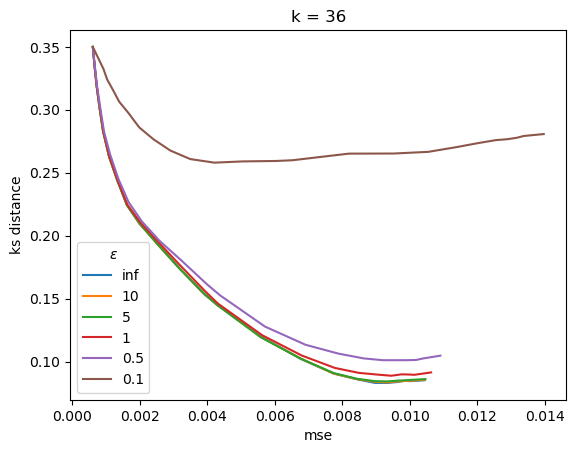

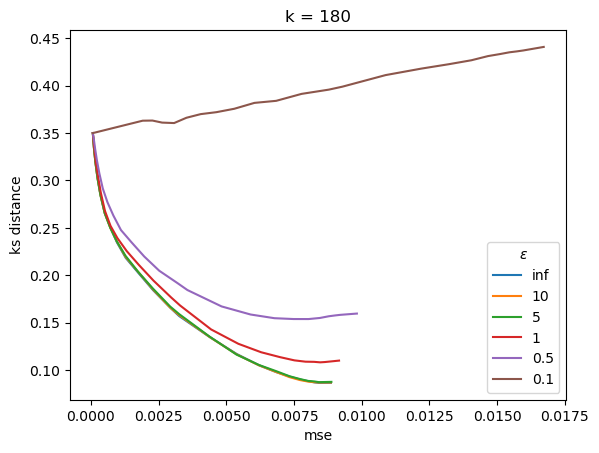

In [9]:
results_mean = all_results.mean(axis=-1)
for i, k in enumerate(sweep_k):
  fig, ax = plt.subplots(1, 1)
  for j, eps in enumerate(epsilons):
    ax.plot(*results_mean[:, j, i], label=f"{eps}")
  plt.legend(title=r"$\epsilon$")
  ax.set_xlabel("mse")
  ax.set_ylabel("ks distance")
  plt.title(f"k = {k}")
  plt.show()

### Sweep $k$ and $\alpha$ ($\epsilon=0.1$)

In [11]:
sweep_k = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 24, 26, 28, 30, 36, 42, 48, 54, 60
]
eps = 0.1
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.1), 10)),
    np.linspace(0.11, 0.35, 12),
    [1.0],
])
print(f"alphas = {alphas}")

results = process_map(
    postprocess_and_evaluate,
    [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
     for seed in seeds],
    max_workers=max_workers,
)  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
results = np.moveaxis(
    np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1, 0)

alphas = [0.         0.005      0.00697475 0.00972944 0.01357209 0.0189324
 0.02640976 0.03684031 0.05139043 0.07168712 0.1        0.11
 0.13181818 0.15363636 0.17545455 0.19727273 0.21909091 0.24090909
 0.26272727 0.28454545 0.30636364 0.32818182 0.35       1.        ]


/tmp/ipykernel_3656912/3067519339.py:14: TqdmWarning: Iterable length 37200 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  results = process_map(
100%|██████████| 37200/37200 [02:04<00:00, 298.87it/s]


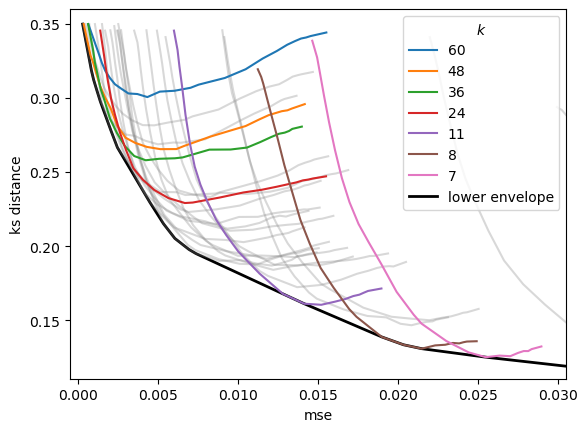

In [12]:
results_mean = results.mean(axis=-1)
fig, ax = plt.subplots(1, 1)
highlighted_k = [7, 8, 11, 24, 36, 48, 60]
for i, k in enumerate(sweep_k):
  if k not in highlighted_k:
    ax.plot(*results_mean[:, i], color="gray", alpha=0.3)
for i, k in list(enumerate(sweep_k))[::-1]:
  if k in highlighted_k:
    ax.plot(*results_mean[:, i], label=f"{k}")

ax.plot(*get_convex_hull_lower(*results_mean.reshape(2, -1)).T,
        color="k",
        label="lower envelope",
        lw=2,
        zorder=0)
plt.legend(title=r"$k$", loc="upper right")
ax.set_xlabel("mse")
ax.set_ylabel("ks distance")
plt.xlim(-0.0005, 0.0305)
plt.ylim(0.1105, 0.36)
plt.show()

### Lower envelopes

In [14]:
sweep_k = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 24, 26, 28, 30, 36, 42, 48, 54, 60
]
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.1), 10)),
    np.linspace(0.11, 0.35, 12),
    [1.0],
])
print(f"alphas = {alphas}")

all_results = []
for eps in epsilons:
  results = process_map(
      postprocess_and_evaluate,
      [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
       for seed in seeds],
      max_workers=max_workers,
      chunksize=1,
  )  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
  results = np.moveaxis(
      np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1,
      0)
  all_results.append(results)
all_results = np.moveaxis(
    np.array(all_results), 0,
    1)  # shape = (2, len(epsilons), len(sweep_k), len(alphas), len(seeds))

alphas = [0.         0.005      0.00697475 0.00972944 0.01357209 0.0189324
 0.02640976 0.03684031 0.05139043 0.07168712 0.1        0.11
 0.13181818 0.15363636 0.17545455 0.19727273 0.21909091 0.24090909
 0.26272727 0.28454545 0.30636364 0.32818182 0.35       1.        ]


100%|██████████| 37200/37200 [02:05<00:00, 296.57it/s]


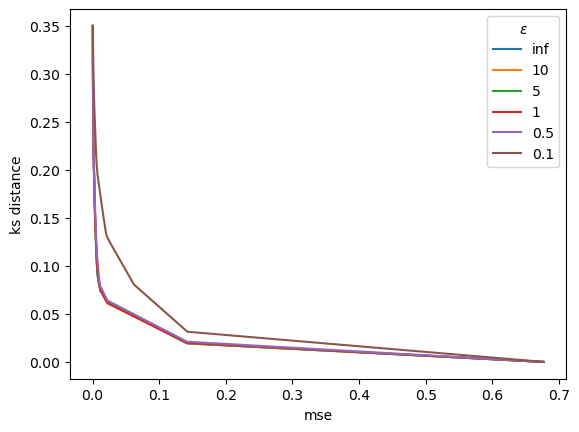

In [15]:
results_mean = all_results.mean(axis=-1)
fig, ax = plt.subplots(1, 1)
for i, eps in enumerate(epsilons):
  ax.plot(*get_convex_hull_lower(*results_mean[:, i].reshape(2, -1)).T,
          label=f"{eps}")
plt.legend(title=r"$\epsilon$")
ax.set_xlabel("mse")
ax.set_ylabel("ks distance")
plt.show()